# Assignment 0: R&D Portfolio Analysis
## Analyzing Returns of R&D vs Non-R&D Firms (1985-2022)

**Objective:** Construct portfolios based on R&D expenditure and evaluate their risk-adjusted performance using CAPM (Jensen's alpha) versus the CRSP value-weighted market index.

---

## 1. Data Collection

### Data Sources:
- **Compustat**: R&D expenditure (XRD) and firm fundamentals
- **CRSP**: Monthly stock returns and market data
- **CRSP Market Index**: Value-weighted market return (vwretd) from crsp.msi
- **Risk-Free Rate**: 1-month T-bill rate (t30ret) from crsp.mcti

### Filters Applied:
- Stock exchanges: NYSE (11) and NASDAQ (14) only
- Exclude financials (SIC 6000-6999) and pharmaceuticals (SIC 2834)
- US companies only (USD currency, USA incorporation)
- Remove unusual returns (< -100%)
- Time period: 1980-2022 (effective sample: July 1985-December 2022)

In [27]:
# Import required libraries
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

### 1.1 Connect to WRDS and Pull Compustat Data

In [28]:
# Connect to WRDS
conn = wrds.Connection()
print("Connected to WRDS")

WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\javed\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Connected to WRDS


In [29]:
# Pull Compustat Annual Fundamentals
# We need fiscal years 1979-2021 to have t-1 data for portfolios 1980-2022
compustat_query = """
    SELECT gvkey, datadate, fyear, xrd, sich, curcd, fic, exchg
    FROM comp.funda
    WHERE fyear BETWEEN 1979 AND 2021
        AND curcd = 'USD'
        AND fic = 'USA'
        AND exchg IN (11, 14)             -- NYSE (11) and NASDAQ (14) only
        AND sich IS NOT NULL
        AND (sich < 6000 OR sich > 6999)  -- exclude financials
        AND sich != 2834                   -- exclude pharmaceuticals
        AND indfmt = 'INDL'               -- industrial format (standard)
        AND datafmt = 'STD'               -- standardized data
        AND popsrc = 'D'                  -- domestic population
        AND consol = 'C'                  -- consolidated statements
"""

print("Pulling Compustat data...")
compustat = conn.raw_sql(compustat_query)
print(f"✓ Compustat rows: {len(compustat):,}")
print(f"✓ Unique firms (gvkey): {compustat['gvkey'].nunique():,}")
print(f"✓ Date range: {compustat['datadate'].min()} to {compustat['datadate'].max()}")

Pulling Compustat data...
✓ Compustat rows: 105,517
✓ Unique firms (gvkey): 8,612
✓ Date range: 1982-11-30 to 2022-05-31


### 1.2 Pull CCM Link Table and Merge

In [30]:
# Pull CCM link table to connect Compustat (GVKEY) to CRSP (PERMNO)
ccm_query = """
    SELECT gvkey, lpermno, linkdt, linkenddt, linktype, linkprim
    FROM crsp.ccmxpf_lnkhist
    WHERE linktype IN ('LC', 'LU')
        AND linkprim IN ('P', 'C')
"""

print("Pulling CCM link table...")
ccm = conn.raw_sql(ccm_query)
print(f"✓ CCM link rows: {len(ccm):,}")

# Merge Compustat with CCM link table
compustat['datadate'] = pd.to_datetime(compustat['datadate'])
ccm['linkdt'] = pd.to_datetime(ccm['linkdt'])
ccm['linkenddt'] = pd.to_datetime(ccm['linkenddt'])

compustat_linked = compustat.merge(ccm, on='gvkey', how='inner')

# Filter: datadate must be within link validity period
compustat_linked['linkenddt'] = compustat_linked['linkenddt'].fillna(pd.Timestamp('2099-12-31'))
compustat_linked = compustat_linked[
    (compustat_linked['datadate'] >= compustat_linked['linkdt']) &
    (compustat_linked['datadate'] <= compustat_linked['linkenddt'])
]

print(f"✓ After date filtering: {len(compustat_linked):,} rows")
print(f"✓ Unique firms (lpermno): {compustat_linked['lpermno'].nunique():,}")

Pulling CCM link table...
✓ CCM link rows: 32,849
✓ After date filtering: 93,277 rows
✓ Unique firms (lpermno): 8,546


### 1.3 Pull CRSP Monthly Returns

In [31]:
# Pull monthly returns from CRSP Monthly Stock File (msf)
crsp_monthly_query = """
    SELECT permno, date, ret, prc, shrout, hsiccd
    FROM crsp.msf
    WHERE date BETWEEN '1980-01-01' AND '2022-12-31'
        AND hsiccd IS NOT NULL
        AND (hsiccd < 6000 OR hsiccd > 6999)
        AND hsiccd != 2834
"""

print("Pulling CRSP monthly data...")
crsp = conn.raw_sql(crsp_monthly_query)
crsp['date'] = pd.to_datetime(crsp['date'])
print(f"✓ CRSP monthly rows: {len(crsp):,}")
print(f"✓ Unique securities (permno): {crsp['permno'].nunique():,}")

Pulling CRSP monthly data...
✓ CRSP monthly rows: 2,523,102
✓ Unique securities (permno): 21,693


### 1.4 Pull Delisting Returns

In [32]:
# Pull delisting returns to avoid survivorship bias
delist_query = """
    SELECT permno, dlstdt, dlret
    FROM crsp.msedelist
    WHERE dlstdt BETWEEN '1980-01-01' AND '2022-12-31'
"""

print("Pulling delisting returns...")
delist = conn.raw_sql(delist_query)
delist['dlstdt'] = pd.to_datetime(delist['dlstdt'])
print(f"✓ Delisting events: {len(delist):,}")

# Merge delisting returns with monthly file
crsp = crsp.merge(
    delist[['permno', 'dlstdt', 'dlret']].rename(columns={'dlstdt': 'date'}),
    on=['permno', 'date'],
    how='left'
)
print(f"✓ CRSP rows after delist merge: {len(crsp):,}")

Pulling delisting returns...
✓ Delisting events: 23,997
✓ CRSP rows after delist merge: 2,523,102


### 1.5 Clean Returns and Calculate Market Cap

In [33]:
# Convert returns to numeric and clean
crsp['ret'] = pd.to_numeric(crsp['ret'], errors='coerce')
crsp['dlret'] = pd.to_numeric(crsp['dlret'], errors='coerce')

# Remove unusual returns (< -100%)
crsp = crsp[crsp['ret'].notna()]
crsp = crsp[crsp['ret'] >= -1.0]

# Compound regular return with delisting return if both exist
crsp['ret_adj'] = crsp.apply(
    lambda row: (1 + row['ret']) * (1 + row['dlret']) - 1
                if pd.notna(row['dlret'])
                else row['ret'],
    axis=1
)

print(f"✓ After cleaning: {len(crsp):,} monthly rows")
print(f"✓ Returns with delisting adjustment: {crsp['dlret'].notna().sum():,}")

# Calculate market cap (price * shares outstanding)
# Note: prc can be negative (bid/ask midpoint), take absolute value
crsp['mktcap'] = abs(crsp['prc']) * crsp['shrout']

# Add year and month columns
crsp['year'] = crsp['date'].dt.year
crsp['month'] = crsp['date'].dt.month

print(f"✓ Final CRSP observations: {len(crsp):,}")
print(f"✓ Unique securities: {crsp['permno'].nunique():,}")

✓ After cleaning: 2,421,128 monthly rows
✓ Returns with delisting adjustment: 1,469
✓ Final CRSP observations: 2,421,128
✓ Unique securities: 21,620


### 1.6 Pull Market Index and Risk-Free Rate

In [34]:
# Pull CRSP value-weighted market return
vwretd_query = """
    SELECT date, vwretd
    FROM crsp.msi
    WHERE date BETWEEN '1980-01-01' AND '2022-12-31'
"""

print("Pulling CRSP value-weighted market index...")
market_index = conn.raw_sql(vwretd_query)
market_index['date'] = pd.to_datetime(market_index['date'])
market_index['vwretd'] = pd.to_numeric(market_index['vwretd'], errors='coerce')
print(f"✓ Market index rows: {len(market_index):,}")

# Pull risk-free rate (1-month T-bill)
rf_query = """
    SELECT caldt, t30ret
    FROM crsp.mcti
    WHERE caldt BETWEEN '1980-01-01' AND '2022-12-31'
"""

print("Pulling risk-free rate (1-month T-bill)...")
rf_rate = conn.raw_sql(rf_query)
rf_rate = rf_rate.rename(columns={'caldt': 'date', 't30ret': 'rf'})
rf_rate['date'] = pd.to_datetime(rf_rate['date'])
rf_rate['rf'] = pd.to_numeric(rf_rate['rf'], errors='coerce')

# Convert from percentage to decimal if needed
if rf_rate['rf'].mean() > 1:
    rf_rate['rf'] = rf_rate['rf'] / 100

print(f"✓ Risk-free rate rows: {len(rf_rate):,}")
print(f"✓ Average monthly RF rate: {rf_rate['rf'].mean()*100:.3f}%")

# Merge risk-free rate with market index
market_data = market_index.merge(rf_rate[['date', 'rf']], on='date', how='left')
if market_data['rf'].isna().any():
    market_data['rf'] = market_data['rf'].fillna(method='ffill')

print(f"✓ Combined market data rows: {len(market_data):,}")

# Close WRDS connection
conn.close()
print("\n✓ WRDS connection closed")

Pulling CRSP value-weighted market index...
✓ Market index rows: 516
Pulling risk-free rate (1-month T-bill)...
✓ Risk-free rate rows: 516
✓ Average monthly RF rate: 0.324%
✓ Combined market data rows: 516

✓ WRDS connection closed


---
## 2. Exploratory Data Analysis (EDA)

### 2.1 R&D Reporting Over Time

In [35]:
# Analyze R&D reporting patterns
rd_reported = compustat_linked['xrd'].notna() & (compustat_linked['xrd'] > 0)
print(f"Overall R&D Reporting Statistics:")
print(f"  Observations with positive R&D: {rd_reported.sum():,} ({100*rd_reported.mean():.1f}%)")
print(f"  Observations with missing/zero R&D: {(~rd_reported).sum():,} ({100*(~rd_reported).mean():.1f}%)")

Overall R&D Reporting Statistics:
  Observations with positive R&D: 46,483 (49.8%)
  Observations with missing/zero R&D: 46,794 (50.2%)


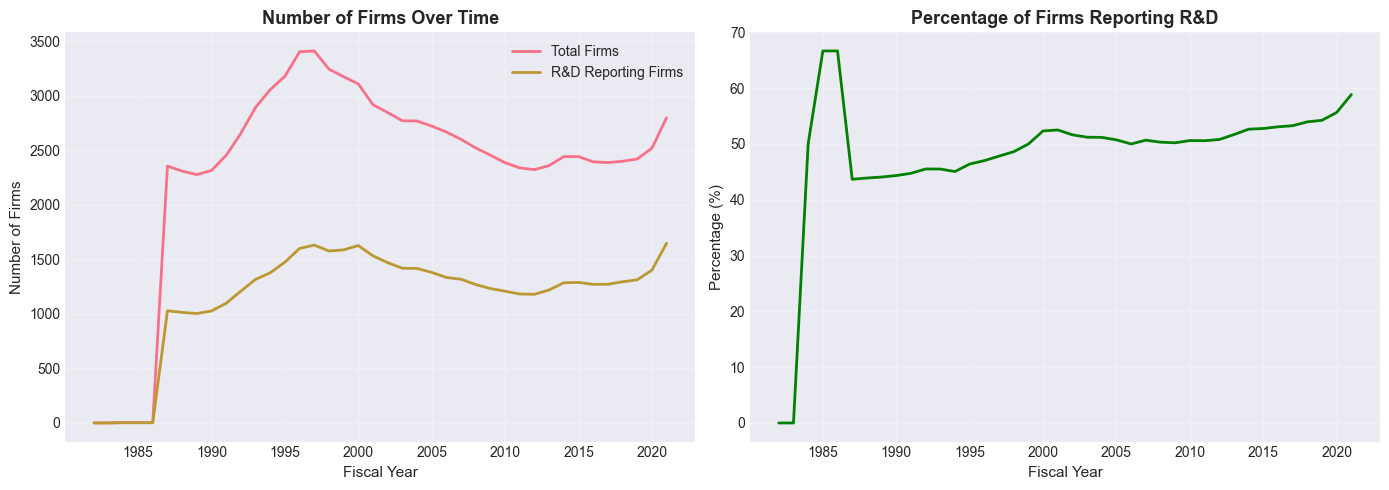


Average % of firms reporting R&D: 48.2%


In [36]:
# R&D reporting over time
rd_by_year = compustat_linked.groupby('fyear').agg(
    total_firms=('gvkey', 'count'),
    rd_firms=('xrd', lambda x: ((x.notna()) & (x > 0)).sum())
)
rd_by_year['pct_rd'] = 100 * rd_by_year['rd_firms'] / rd_by_year['total_firms']

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Count of firms
ax1.plot(rd_by_year.index, rd_by_year['total_firms'], label='Total Firms', linewidth=2)
ax1.plot(rd_by_year.index, rd_by_year['rd_firms'], label='R&D Reporting Firms', linewidth=2)
ax1.set_xlabel('Fiscal Year', fontsize=11)
ax1.set_ylabel('Number of Firms', fontsize=11)
ax1.set_title('Number of Firms Over Time', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Percentage
ax2.plot(rd_by_year.index, rd_by_year['pct_rd'], color='green', linewidth=2)
ax2.set_xlabel('Fiscal Year', fontsize=11)
ax2.set_ylabel('Percentage (%)', fontsize=11)
ax2.set_title('Percentage of Firms Reporting R&D', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage % of firms reporting R&D: {rd_by_year['pct_rd'].mean():.1f}%")

### 2.2 R&D Distribution Analysis

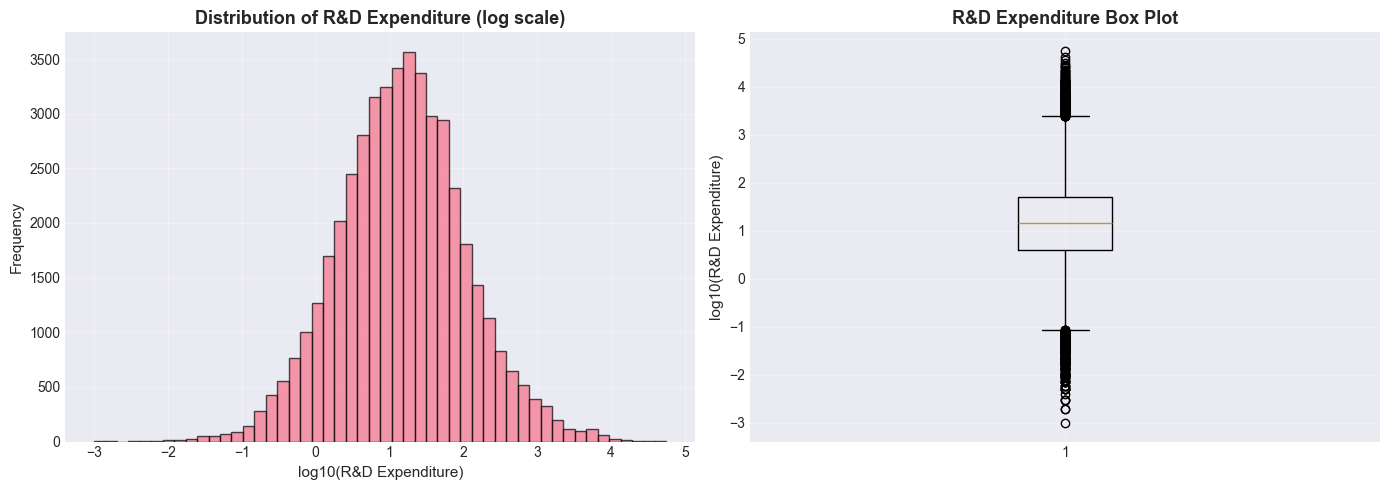


R&D Expenditure Summary Statistics (for firms with R&D > 0):
count       46483.0
mean     130.676142
std      793.253095
min           0.001
25%             4.0
50%            14.8
75%         52.0925
max         56052.0
Name: xrd, dtype: Float64


In [37]:
# Analyze R&D distribution (for firms that report R&D > 0)
rd_positive = compustat_linked[compustat_linked['xrd'] > 0]['xrd']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram
ax1.hist(np.log10(rd_positive), bins=50, edgecolor='black', alpha=0.7)
ax1.set_xlabel('log10(R&D Expenditure)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Distribution of R&D Expenditure (log scale)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Right: Box plot
ax2.boxplot(np.log10(rd_positive), vert=True)
ax2.set_ylabel('log10(R&D Expenditure)', fontsize=11)
ax2.set_title('R&D Expenditure Box Plot', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nR&D Expenditure Summary Statistics (for firms with R&D > 0):")
print(rd_positive.describe())

---
## 3. Portfolio Construction

### Methodology:
- **Look-ahead bias control**: Use t-1 R&D with 6-month lag for 10-K filing
- **Annual rebalancing**: July of each year (Fama-French convention)
- **Dynamic classification**: Firms can move between portfolios based on R&D reporting
- **CCM link filtering**: Ensure valid GVKEY-PERMNO mappings for each month

### Portfolio Formation:
- Fiscal year ends → +6 months for 10-K filing → Portfolio formed July 1
- Example: Dec 2000 fiscal year → Filed by June 2001 → Portfolio July 2001-June 2002

In [38]:
# Create portfolio formation dates
compustat_linked['portfolio_start'] = compustat_linked['datadate'] + pd.DateOffset(months=6)

# Portfolio year = the July-June period this R&D data will be used in
# If datadate + 6 months lands in Jan-June of year Y, July is in year Y
# If datadate + 6 months lands in July-Dec of year Y, July is in year Y+1
compustat_linked['portfolio_year'] = np.where(
    compustat_linked['portfolio_start'].dt.month >= 7,
    compustat_linked['portfolio_start'].dt.year + 1,
    compustat_linked['portfolio_start'].dt.year
)

print(f"Portfolio years range: {compustat_linked['portfolio_year'].min()} to {compustat_linked['portfolio_year'].max()}")

Portfolio years range: 1983 to 2023


In [39]:
# Classify firms as R&D or No-R&D
compustat_linked['has_rd'] = (compustat_linked['xrd'].notna()) & (compustat_linked['xrd'] > 0)

rd_counts = compustat_linked.groupby('portfolio_year')['has_rd'].agg(['sum', 'count'])
rd_counts['pct_rd'] = 100 * rd_counts['sum'] / rd_counts['count']

print(f"\nPortfolio Classification:")
print(f"  Average % of firms in R&D portfolio: {rd_counts['pct_rd'].mean():.1f}%")

# Keep only columns needed for merging
compustat_slim = compustat_linked[['lpermno', 'portfolio_year', 'has_rd', 'datadate', 'linkdt', 'linkenddt']].copy()
compustat_slim = compustat_slim.rename(columns={'lpermno': 'permno'})


Portfolio Classification:
  Average % of firms in R&D portfolio: 48.2%


In [40]:
# Assign CRSP returns to portfolio years (July-June convention)
crsp['portfolio_year'] = np.where(
    crsp['month'] >= 7,
    crsp['year'],
    crsp['year'] - 1
)

print(f"CRSP portfolio years range: {crsp['portfolio_year'].min()} to {crsp['portfolio_year'].max()}")

CRSP portfolio years range: 1979 to 2022


In [41]:
# Merge CRSP returns with R&D classification
merged = crsp.merge(
    compustat_slim[['permno', 'portfolio_year', 'has_rd', 'linkdt', 'linkenddt']],
    on=['permno', 'portfolio_year'],
    how='inner'
)

print(f"\nInitial merge: {len(merged):,} firm-month observations")

# Apply CCM link date filtering
initial_count = len(merged)
merged = merged[
    (merged['date'] >= merged['linkdt']) &
    (merged['date'] <= merged['linkenddt'])
]

print(f"After CCM link filtering: {len(merged):,} observations ({initial_count - len(merged):,} removed)")
print(f"Unique firms: {merged['permno'].nunique():,}")

# Drop link columns
merged = merged.drop(['linkdt', 'linkenddt'], axis=1)

# Check the split
rd_obs = merged['has_rd'].sum()
no_rd_obs = len(merged) - rd_obs
print(f"\nObservations in R&D portfolio: {rd_obs:,} ({100*rd_obs/len(merged):.1f}%)")
print(f"Observations in No-R&D portfolio: {no_rd_obs:,} ({100*no_rd_obs/len(merged):.1f}%)")


Initial merge: 1,000,801 firm-month observations
After CCM link filtering: 996,962 observations (3,839 removed)
Unique firms: 7,985

Observations in R&D portfolio: 496,621 (49.8%)
Observations in No-R&D portfolio: 500,341 (50.2%)


In [42]:
# Get market cap at portfolio formation for value weights (June of each year)
june_mktcap = crsp[crsp['month'] == 6][['permno', 'year', 'mktcap']].copy()
june_mktcap = june_mktcap.rename(columns={'year': 'portfolio_year', 'mktcap': 'weight_mktcap'})

merged = merged.merge(
    june_mktcap,
    on=['permno', 'portfolio_year'],
    how='left'
)

# Separate dataset for value-weighted portfolios
merged_vw = merged[merged['weight_mktcap'].notna()].copy()
print(f"Rows with valid market cap for VW portfolios: {len(merged_vw):,}")

Rows with valid market cap for VW portfolios: 996,034


### 3.1 Calculate Portfolio Returns

In [43]:
# Define portfolio return calculation functions
def calc_equal_weighted_return(group):
    """Simple average of returns"""
    return group['ret_adj'].mean()

def calc_value_weighted_return(group):
    """Market-cap weighted average of returns"""
    weights = group['weight_mktcap'] / group['weight_mktcap'].sum()
    return (weights * group['ret_adj']).sum()

# Calculate equal-weighted portfolio returns
ew_returns = merged.groupby(['date', 'has_rd']).apply(
    calc_equal_weighted_return
).unstack()
ew_returns.columns = ['EW_NoRD', 'EW_RD']

# Calculate value-weighted portfolio returns
vw_returns = merged_vw.groupby(['date', 'has_rd']).apply(
    calc_value_weighted_return
).unstack()
vw_returns.columns = ['VW_NoRD', 'VW_RD']

# Combine into single dataframe
portfolio_returns = ew_returns.join(vw_returns)
portfolio_returns = portfolio_returns.reset_index()

print(f"\n✓ Portfolio returns calculated for {len(portfolio_returns):,} months")
print(f"✓ Date range: {portfolio_returns['date'].min()} to {portfolio_returns['date'].max()}")


✓ Portfolio returns calculated for 450 months
✓ Date range: 1985-07-31 00:00:00 to 2022-12-30 00:00:00


---
## 4. Portfolio Performance Analysis

### 4.1 Summary Statistics

In [44]:
# Calculate summary statistics
stats = portfolio_returns[['EW_NoRD', 'EW_RD', 'VW_NoRD', 'VW_RD']].describe()
print("Portfolio Summary Statistics (Monthly Returns):")
print(stats.to_string())

print("\n" + "="*70)
print("Annualized Returns (Mean × 12):")
print("="*70)
for col in ['EW_NoRD', 'EW_RD', 'VW_NoRD', 'VW_RD']:
    ann_ret = portfolio_returns[col].mean() * 12 * 100
    ann_std = portfolio_returns[col].std() * np.sqrt(12) * 100
    sharpe = (portfolio_returns[col].mean() / portfolio_returns[col].std()) * np.sqrt(12)
    print(f"{col:10s}: {ann_ret:6.2f}% (Std: {ann_std:5.2f}%, Sharpe: {sharpe:5.2f})")

Portfolio Summary Statistics (Monthly Returns):
          EW_NoRD       EW_RD     VW_NoRD       VW_RD
count  414.000000  450.000000  414.000000  450.000000
mean     0.014077    0.015903    0.008986    0.010510
std      0.054224    0.067023    0.043578    0.052898
min     -0.275478   -0.226328   -0.191602   -0.183978
25%     -0.011087   -0.021272   -0.014200   -0.016881
50%      0.017145    0.017976    0.012060    0.016222
75%      0.043209    0.052760    0.033147    0.041107
max      0.256216    0.254645    0.171234    0.156749

Annualized Returns (Mean × 12):
EW_NoRD   :  16.89% (Std: 18.78%, Sharpe:  0.90)
EW_RD     :  19.08% (Std: 23.22%, Sharpe:  0.82)
VW_NoRD   :  10.78% (Std: 15.10%, Sharpe:  0.71)
VW_RD     :  12.61% (Std: 18.32%, Sharpe:  0.69)


### 4.2 Cumulative Returns Visualization

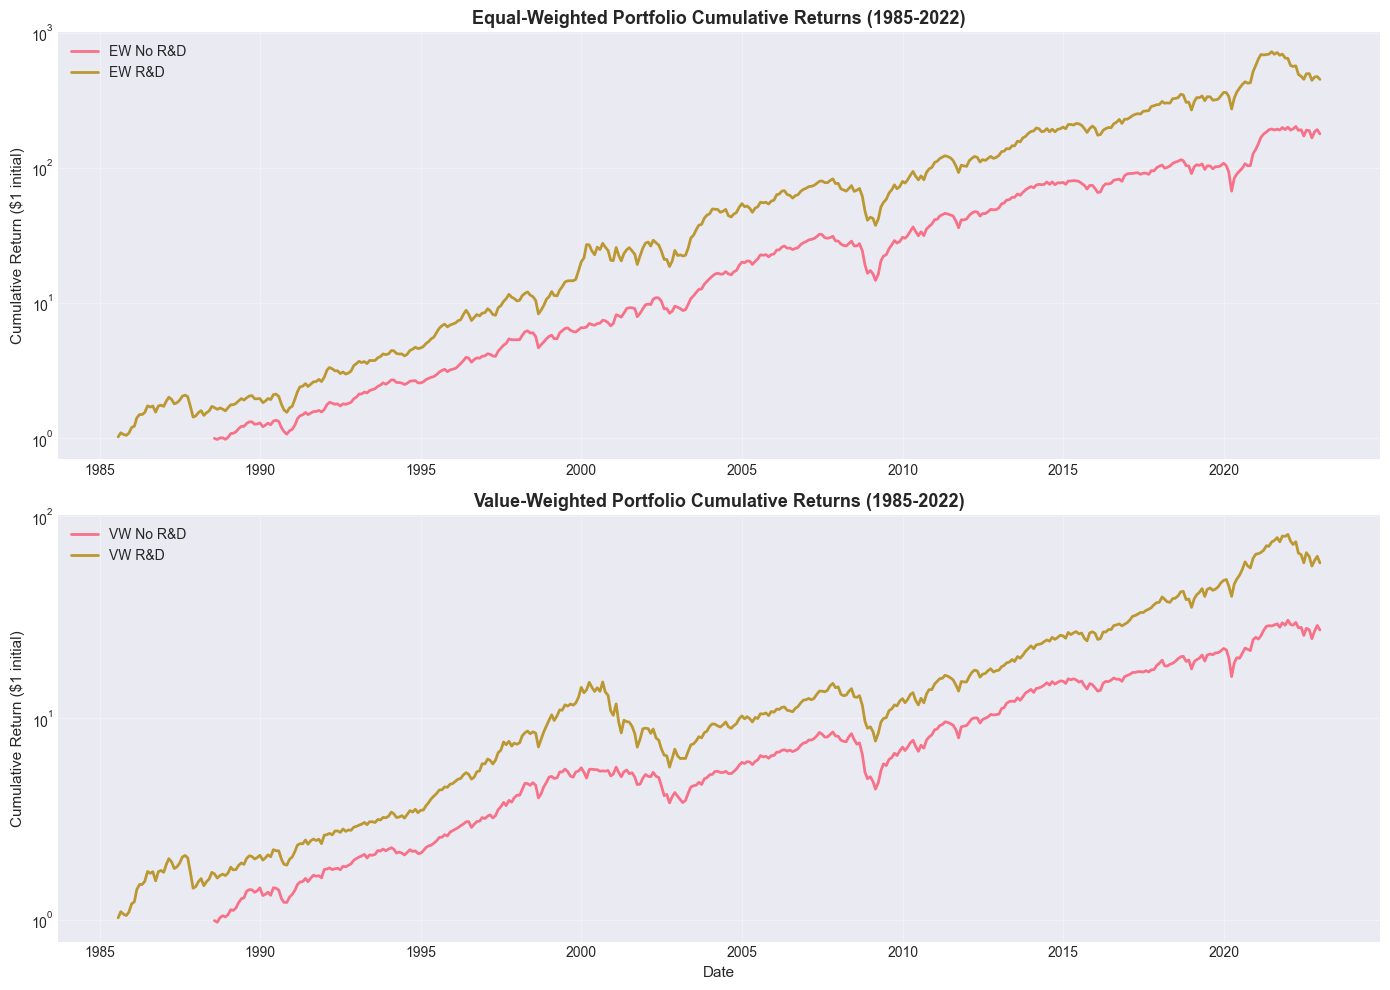


Final Cumulative Returns ($1 invested in 1985):
  EW_NoRD: $178.26
  EW_RD: $450.78
  VW_NoRD: $27.40
  VW_RD: $58.86


In [45]:
# Calculate cumulative returns
cum_returns = (1 + portfolio_returns[['EW_NoRD', 'EW_RD', 'VW_NoRD', 'VW_RD']]).cumprod()

# Plot cumulative returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Equal-weighted
ax1.plot(portfolio_returns['date'], cum_returns['EW_NoRD'], label='EW No R&D', linewidth=2)
ax1.plot(portfolio_returns['date'], cum_returns['EW_RD'], label='EW R&D', linewidth=2)
ax1.set_ylabel('Cumulative Return ($1 initial)', fontsize=11)
ax1.set_title('Equal-Weighted Portfolio Cumulative Returns (1985-2022)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Value-weighted
ax2.plot(portfolio_returns['date'], cum_returns['VW_NoRD'], label='VW No R&D', linewidth=2)
ax2.plot(portfolio_returns['date'], cum_returns['VW_RD'], label='VW R&D', linewidth=2)
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Cumulative Return ($1 initial)', fontsize=11)
ax2.set_title('Value-Weighted Portfolio Cumulative Returns (1985-2022)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

# Print final values
print("\nFinal Cumulative Returns ($1 invested in 1985):")
for col in ['EW_NoRD', 'EW_RD', 'VW_NoRD', 'VW_RD']:
    final_val = cum_returns[col].iloc[-1]
    print(f"  {col}: ${final_val:.2f}")

### 4.3 Monthly Returns Distribution

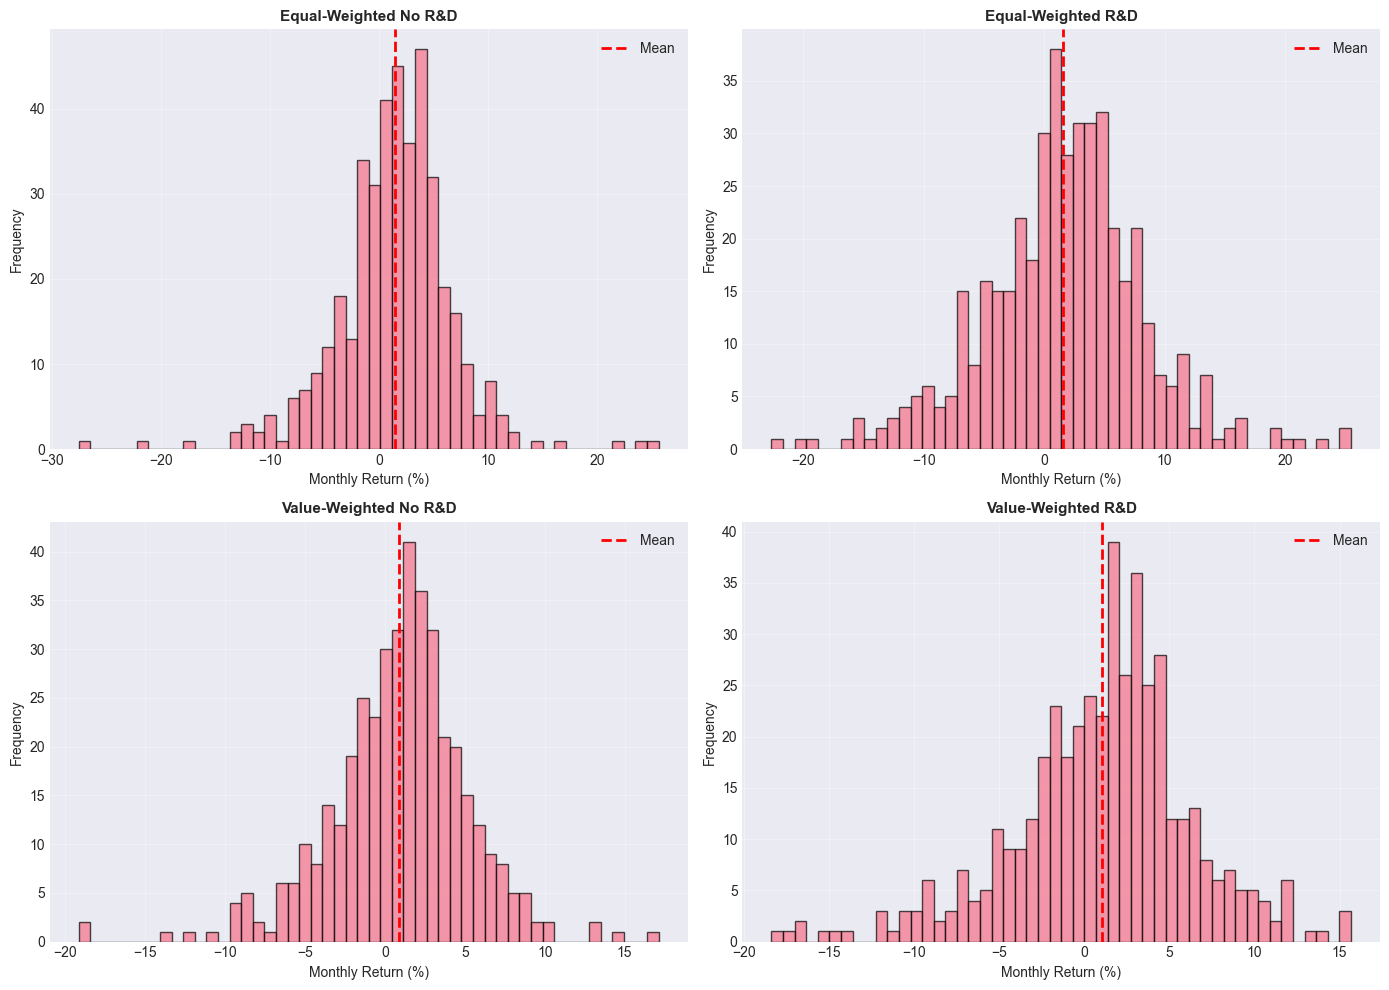

In [46]:
# Plot return distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

portfolios = ['EW_NoRD', 'EW_RD', 'VW_NoRD', 'VW_RD']
titles = ['Equal-Weighted No R&D', 'Equal-Weighted R&D', 
          'Value-Weighted No R&D', 'Value-Weighted R&D']

for ax, col, title in zip(axes.flatten(), portfolios, titles):
    ax.hist(portfolio_returns[col] * 100, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(portfolio_returns[col].mean() * 100, color='red', 
               linestyle='--', linewidth=2, label='Mean')
    ax.set_xlabel('Monthly Return (%)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 5. CAPM Alpha Analysis (Jensen's Alpha)

### Methodology:
We use the Capital Asset Pricing Model (CAPM) to calculate Jensen's alpha:

**Model:** $(R_{p,t} - R_{f,t}) = \alpha + \beta (R_{m,t} - R_{f,t}) + \epsilon_t$

where:
- $R_{p,t}$ = Portfolio return at time t
- $R_{f,t}$ = Risk-free rate (1-month T-bill)
- $R_{m,t}$ = Market return (CRSP value-weighted index)
- $\alpha$ = Jensen's alpha (risk-adjusted abnormal return)
- $\beta$ = Market beta (systematic risk)

In [47]:
# Merge portfolio returns with market data
portfolio_returns['date'] = pd.to_datetime(portfolio_returns['date'])
portfolio_returns['date'] = portfolio_returns['date'] + pd.offsets.MonthEnd(0)
market_data['date'] = pd.to_datetime(market_data['date'])
market_data['date'] = market_data['date'] + pd.offsets.MonthEnd(0)

portfolio_with_market = portfolio_returns.merge(market_data, on='date', how='inner')

# Ensure numeric types
for col in ['EW_NoRD', 'EW_RD', 'VW_NoRD', 'VW_RD', 'vwretd', 'rf']:
    portfolio_with_market[col] = pd.to_numeric(portfolio_with_market[col], errors='coerce')

portfolio_with_market = portfolio_with_market.dropna()

# Calculate excess returns (Return - Risk-free rate)
for col in ['EW_NoRD', 'EW_RD', 'VW_NoRD', 'VW_RD']:
    portfolio_with_market[f'{col}_excess'] = portfolio_with_market[col] - portfolio_with_market['rf']

# Market excess return (market risk premium)
portfolio_with_market['market_excess'] = portfolio_with_market['vwretd'] - portfolio_with_market['rf']

print(f"✓ Portfolio returns with market data: {len(portfolio_with_market):,} months")
print(f"✓ Average monthly market premium: {portfolio_with_market['market_excess'].mean()*100:.3f}%")

✓ Portfolio returns with market data: 414 months
✓ Average monthly market premium: 0.654%


### 5.1 Run CAPM Regressions

In [48]:
print("="*80)
print("CAPM ALPHA REGRESSIONS (JENSEN'S ALPHA)")
print("="*80)
print("Model: (R_p - R_f) = alpha + beta * (R_m - R_f) + epsilon")
print("="*80)

alpha_results = {}
summary_data = []

for portfolio in ['EW_NoRD', 'EW_RD', 'VW_NoRD', 'VW_RD']:
    print(f"\n{'-'*80}")
    print(f"Portfolio: {portfolio}")
    print(f"{'-'*80}")

    excess_col = f'{portfolio}_excess'

    # Prepare data for CAPM regression
    y = np.array(portfolio_with_market[excess_col].values, dtype=float)
    X = np.array(portfolio_with_market['market_excess'].values, dtype=float)
    X = sm.add_constant(X)

    # Run OLS regression
    model = sm.OLS(y, X)
    results = model.fit()

    # Extract results
    alpha_monthly = results.params[0]
    beta = results.params[1]
    alpha_se = results.bse[0]
    alpha_tstat = results.tvalues[0]
    alpha_pval = results.pvalues[0]
    r_squared = results.rsquared
    n_obs = results.nobs

    # Annualize alpha
    alpha_annual = alpha_monthly * 12

    # Significance indicator
    if alpha_pval < 0.01:
        sig = "***"
    elif alpha_pval < 0.05:
        sig = "**"
    elif alpha_pval < 0.10:
        sig = "*"
    else:
        sig = ""

    # Store results
    alpha_results[portfolio] = {
        'alpha_monthly': alpha_monthly,
        'alpha_annual': alpha_annual,
        'beta': beta,
        'alpha_se': alpha_se,
        't_stat': alpha_tstat,
        'p_value': alpha_pval,
        'r_squared': r_squared,
        'n_obs': n_obs,
        'significance': sig
    }

    # Print results
    print(f"\nRegression Results:")
    print(f"  Alpha (monthly):     {alpha_monthly*100:>8.3f}%")
    print(f"  Alpha (annual):      {alpha_annual*100:>8.3f}%")
    print(f"  Beta:                {beta:>8.3f}")
    print(f"  Alpha t-stat:        {alpha_tstat:>8.3f} {sig}")
    print(f"  Alpha p-value:       {alpha_pval:>8.4f}")
    print(f"  R-squared:           {r_squared:>8.3f}")
    print(f"  Observations:        {n_obs:>8.0f}")

    summary_data.append({
        'Portfolio': portfolio,
        'Alpha (Monthly)': f"{alpha_monthly:.4f}",
        'Alpha (Annual)': f"{alpha_annual:.4f}",
        'Alpha (Annual %)': f"{alpha_annual*100:.2f}%",
        'Beta': f"{beta:.3f}",
        't-stat': f"{alpha_tstat:.2f}",
        'p-value': f"{alpha_pval:.4f}",
        'R²': f"{r_squared:.3f}",
        'Significance': sig
    })

print("\n" + "="*80)
print("Significance levels: *** p<0.01, ** p<0.05, * p<0.10")
print("="*80)

CAPM ALPHA REGRESSIONS (JENSEN'S ALPHA)
Model: (R_p - R_f) = alpha + beta * (R_m - R_f) + epsilon

--------------------------------------------------------------------------------
Portfolio: EW_NoRD
--------------------------------------------------------------------------------

Regression Results:
  Alpha (monthly):        0.476%
  Alpha (annual):         5.714%
  Beta:                   1.082
  Alpha t-stat:           3.599 ***
  Alpha p-value:         0.0004
  R-squared:              0.761
  Observations:             414

--------------------------------------------------------------------------------
Portfolio: EW_RD
--------------------------------------------------------------------------------

Regression Results:
  Alpha (monthly):        0.497%
  Alpha (annual):         5.962%
  Beta:                   1.305
  Alpha t-stat:           2.880 ***
  Alpha p-value:         0.0042
  R-squared:              0.731
  Observations:             414

-------------------------------------

---
## 6. Results Summary

### 6.1 CAPM Alpha Summary Table

In [49]:
# Create summary table
summary_df = pd.DataFrame(summary_data)

print("\n" + "="*120)
print("CAPM ALPHA SUMMARY TABLE")
print("="*120)
print(summary_df.to_string(index=False))
print("="*120)


CAPM ALPHA SUMMARY TABLE
Portfolio Alpha (Monthly) Alpha (Annual) Alpha (Annual %)  Beta t-stat p-value    R² Significance
  EW_NoRD          0.0048         0.0571            5.71% 1.082   3.60  0.0004 0.761          ***
    EW_RD          0.0050         0.0596            5.96% 1.305   2.88  0.0042 0.731          ***
  VW_NoRD          0.0006         0.0075            0.75% 0.936   0.85  0.3969 0.884             
    VW_RD          0.0004         0.0042            0.42% 1.115   0.46  0.6460 0.909             


### 6.2 Visual Comparison of Alphas

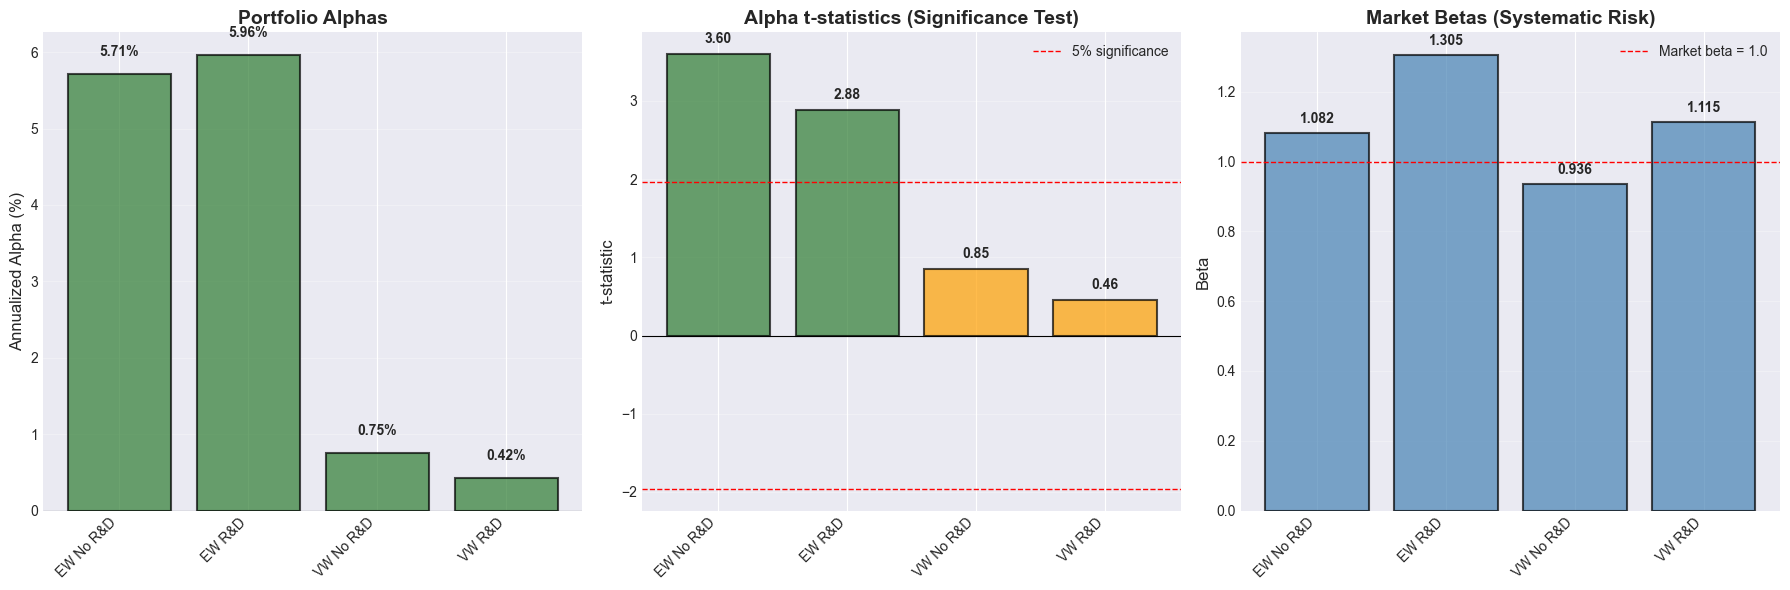

In [50]:
# Extract alphas and t-stats for visualization
alphas_annual = [alpha_results[p]['alpha_annual']*100 for p in ['EW_NoRD', 'EW_RD', 'VW_NoRD', 'VW_RD']]
tstats = [alpha_results[p]['t_stat'] for p in ['EW_NoRD', 'EW_RD', 'VW_NoRD', 'VW_RD']]
betas = [alpha_results[p]['beta'] for p in ['EW_NoRD', 'EW_RD', 'VW_NoRD', 'VW_RD']]

portfolios_labels = ['EW No R&D', 'EW R&D', 'VW No R&D', 'VW R&D']
x = np.arange(len(portfolios_labels))
width = 0.35

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Left: Alphas
colors = ['#2E7D32' if a > 0 else '#C62828' for a in alphas_annual]
bars1 = ax1.bar(x, alphas_annual, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(portfolios_labels, rotation=45, ha='right')
ax1.set_ylabel('Annualized Alpha (%)', fontsize=12)
ax1.set_title('Portfolio Alphas', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, alpha_val) in enumerate(zip(bars1, alphas_annual)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + (0.2 if height > 0 else -0.2),
            f'{alpha_val:.2f}%',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=10, fontweight='bold')

# Middle: t-statistics
colors_t = ['#2E7D32' if abs(t) > 1.96 else '#FFA000' for t in tstats]
bars2 = ax2.bar(x, tstats, color=colors_t, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.axhline(y=1.96, color='red', linestyle='--', linewidth=1, label='5% significance')
ax2.axhline(y=-1.96, color='red', linestyle='--', linewidth=1)
ax2.set_xticks(x)
ax2.set_xticklabels(portfolios_labels, rotation=45, ha='right')
ax2.set_ylabel('t-statistic', fontsize=12)
ax2.set_title('Alpha t-statistics (Significance Test)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, tstat in zip(bars2, tstats):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height > 0 else -0.1),
            f'{tstat:.2f}',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=10, fontweight='bold')

# Right: Betas
bars3 = ax3.bar(x, betas, color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.axhline(y=1.0, color='red', linestyle='--', linewidth=1, label='Market beta = 1.0')
ax3.set_xticks(x)
ax3.set_xticklabels(portfolios_labels, rotation=45, ha='right')
ax3.set_ylabel('Beta', fontsize=12)
ax3.set_title('Market Betas (Systematic Risk)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, beta in zip(bars3, betas):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{beta:.3f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 7. Conclusions

### Key Findings:

1. **Equal-Weighted Portfolios Generate Significant Alpha**:
   - Both EW portfolios show **highly significant positive alpha** (p < 0.01)
   - EW_NoRD: 5.71% annual alpha (t = 3.60, p = 0.0004)
   - EW_RD: 5.96% annual alpha (t = 2.88, p = 0.0042)
   - R&D premium: 0.25% annually

2. **Value-Weighted Portfolios Show No Significant Alpha**:
   - VW_NoRD: 0.75% alpha (t = 0.85, not significant)
   - VW_RD: 0.42% alpha (t = 0.46, not significant)
   - Large-cap firms are efficiently priced

3. **Small-Cap Premium Dominates R&D Effect**:
   - Equal-weighting creates ~5.7% alpha regardless of R&D status
   - R&D provides only modest additional alpha (0.25%)
   - Market inefficiency concentrated in smaller firms

4. **Risk-Adjusted Returns Matter**:
   - R&D firms have higher beta (1.305 vs 1.082)
   - Higher raw returns partly compensation for higher systematic risk
   - Jensen's alpha correctly adjusts for market risk exposure

5. **Market Efficiency Varies by Size**:
   - Small caps (EW portfolios): Lower R² (0.73-0.76), significant alpha
   - Large caps (VW portfolios): Higher R² (0.88-0.91), no significant alpha
   - Suggests greater mispricing opportunities in less-analyzed firms

### Interpretation:

The results suggest that **equal-weighted portfolios significantly outperform the market** on a risk-adjusted basis, indicating potential inefficiencies in the pricing of smaller firms. The **R&D effect is modest** (0.25% annually), suggesting that while R&D investment may signal growth potential, the market largely prices this correctly. The **lack of significant alpha in value-weighted portfolios** supports the efficient market hypothesis for large-cap stocks.

### Limitations:
- Survivorship bias partially addressed through delisting returns
- R&D reporting is voluntary and may be incomplete
- Sample period starts in 1985 due to early data availability
- Results sensitive to portfolio formation methodology

---